In [25]:
import numpy as np
import pandas as pd

train = pd.read_csv('E:/PhD/First year/courses/9309/Project/IEEE-CIS fraud detection/ieee-fraud-detection/train_transaction.csv')
test = pd.read_csv('E:/PhD/First year/courses/9309/Project/IEEE-CIS fraud detection/ieee-fraud-detection/test_transaction.csv')
sub = pd.read_csv('E:/PhD/First year/courses/9309/Project/IEEE-CIS fraud detection/ieee-fraud-detection/sample_submission.csv')


In [26]:
useful_features = list(train.iloc[:, 3:55].columns)

y = train.sort_values('TransactionDT')['isFraud']
X = train.sort_values('TransactionDT')[useful_features]
X_test = test[useful_features]
del train, test

categorical_features = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain',
    'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'
]

continuous_features = list(filter(lambda x: x not in categorical_features, X))

class ContinuousFeatureConverter:
    def __init__(self, name, feature, log_transform):
        self.name = name
        self.skew = feature.skew()
        self.log_transform = log_transform
        
    def transform(self, feature):
        if self.skew > 1:
            feature = self.log_transform(feature)
        
        mean = feature.mean()
        std = feature.std()
        return (feature - mean)/(std + 1e-6)  
    

In [27]:
from tqdm.autonotebook import tqdm

feature_converters = {}
continuous_features_processed = []
continuous_features_processed_test = []

for f in tqdm(continuous_features):
    feature = X[f]
    feature_test = X_test[f]
    log = lambda x: np.log10(x + 1 - min(0, x.min()))
    converter = ContinuousFeatureConverter(f, feature, log)
    feature_converters[f] = converter
    continuous_features_processed.append(converter.transform(feature))
    continuous_features_processed_test.append(converter.transform(feature_test))
    
continuous_train = pd.DataFrame({s.name: s for s in continuous_features_processed}).astype(np.float32)
continuous_test = pd.DataFrame({s.name: s for s in continuous_features_processed_test}).astype(np.float32)

In [28]:
continuous_train['isna_sum'] = continuous_train.isna().sum(axis=1)
continuous_test['isna_sum'] = continuous_test.isna().sum(axis=1)

continuous_train['isna_sum'] = (continuous_train['isna_sum'] - continuous_train['isna_sum'].mean())/continuous_train['isna_sum'].std()
continuous_test['isna_sum'] = (continuous_test['isna_sum'] - continuous_test['isna_sum'].mean())/continuous_test['isna_sum'].std()
isna_columns = []
for column in tqdm(continuous_features):
    isna = continuous_train[column].isna()
    if isna.mean() > 0.:
        continuous_train[column + '_isna'] = isna.astype(int)
        continuous_test[column + '_isna'] = continuous_test[column].isna().astype(int)
        isna_columns.append(column)
        
continuous_train = continuous_train.fillna(0.)
continuous_test = continuous_test.fillna(0.)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.autonotebook import tqdm

def categorical_encode(df_train, df_test, categorical_features, n_values=50):
    df_train = df_train[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
    
    categories = []
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        df_test[column] = df_test[column].apply(lambda x: x if x in values2use else 'Other')
        
    
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(pd.concat([df_train, df_test]))
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    df_test = pd.DataFrame(ohe.transform(df_test).toarray()).astype(np.float16)
    return df_train, df_test

train_categorical, test_categorical = categorical_encode(X, X_test, categorical_features)

X = pd.concat([continuous_train, train_categorical], axis=1)
del continuous_train, train_categorical
X_test = pd.concat([continuous_test, test_categorical], axis=1)
del continuous_test, test_categorical

In [29]:
split_ind = int(X.shape[0]*0.8)

X_tr = X.iloc[:split_ind]
X_val = X.iloc[split_ind:]

y_tr = y.iloc[:split_ind]
y_val = y.iloc[split_ind:]

print(X_tr.shape[1],)
del X

505


In [6]:
import keras
import random
import tensorflow as tf
import keras.backend as K

from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

np.random.seed(42) # NumPy
random.seed(42) # Python
tf.set_random_seed(42) # Tensorflow

Using TensorFlow backend.
d:\python\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synon

In [7]:
# Compatible with tensorflow backend
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_val: %s' % (str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
    
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Activation(custom_gelu)})
get_custom_objects().update({'focal_loss_fn': focal_loss()})

In [8]:
def create_model(loss_fn):
    inps = Input(shape=(X_tr.shape[1],))
    x = Dense(512, activation=custom_gelu)(inps)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation=custom_gelu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer=Nadam(),
        loss=[loss_fn]
    )
    #model.summary()
    return model
model_focal = create_model('focal_loss_fn')
model_bce = create_model('binary_crossentropy')
model_bce.fit(
    X_tr, y_tr, epochs=8, batch_size=2048, validation_data=(X_val, y_val), verbose=True, 
    callbacks=[roc_callback(training_data=(X_val, y_tr), validation_data=(X_val, y_val))]
)
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.utils import plot_model
plot_model(model_bce, to_file='./model2.png', show_shapes=True)
# model_focal.fit(
#     X_tr, y_tr, epochs=8, batch_size=2048, validation_data=(X_val, y_val), verbose=True, 
#     callbacks=[roc_callback(training_data=(X_val, y_tr), validation_data=(X_val, y_val))]
# )

Train on 472432 samples, validate on 118108 samples
Epoch 1/8
472432/472432 [==============================] - 58s 123us/step - loss: 0.2231 - val_loss: 0.1089
roc-auc_val: 0.8635                                                                                                    
Epoch 2/8
472432/472432 [==============================] - 53s 113us/step - loss: 0.1280 - val_loss: 0.1021
roc-auc_val: 0.889                                                                                                    
Epoch 3/8
472432/472432 [==============================] - 55s 116us/step - loss: 0.0996 - val_loss: 0.1016
roc-auc_val: 0.881                                                                                                    
Epoch 4/8
472432/472432 [==============================] - 57s 121us/step - loss: 0.0788 - val_loss: 0.0988
roc-auc_val: 0.8951                                                                                                    
Epoch 5/8
472432/472432 [=============

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

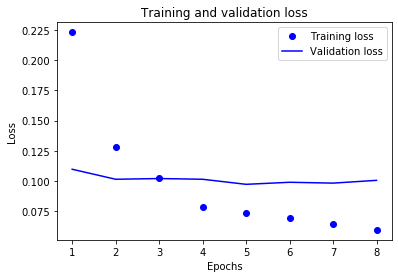

In [3]:
import matplotlib.pyplot as plt

loss =[0.2232,0.1277,0.1022,0.0787, 0.0734,0.0690,0.0645,0.0593]
val_loss =[0.1096,0.1013,0.1019,0.1013,0.0971,0.0988,0.0981,0.1004]


epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [4]:
import matplotlib.pyplot as plt
val_preds_bce = model_bce.predict(X_val).flatten()
val_preds_focal = model_focal.predict(X_val).flatten()
from scipy.stats import rankdata, spearmanr

print('BCE preds: ', roc_auc_score(y_val, val_preds_bce))
print('Focal preds: ',roc_auc_score(y_val, val_preds_focal))
print('Correlation matrix: ')
print(np.corrcoef(val_preds_bce, val_preds_focal))
print("Spearman's correlation: ", spearmanr(val_preds_bce, val_preds_focal).correlation)
print('Averaging: ', roc_auc_score(y_val, val_preds_bce + val_preds_focal))
print('Rank averaging: ', roc_auc_score(y_val, rankdata(val_preds_bce, method='dense') + rankdata(val_preds_focal, method='dense')))
from sklearn import metrics
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = metrics.roc_curve(y_val, val_preds_bce, pos_label = 1)
metrics.auc(fpr, tpr) 
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()

In [30]:
print("Saving model to disk \n")
mp = "E:\PhD\First year\courses\9309\Project\presentation\iris_model.h5"
model_bce.save(mp)

Saving model to disk 



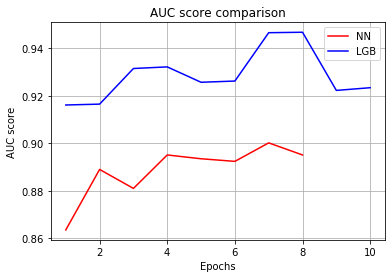

In [3]:
import matplotlib.pyplot as plt
roc1=[0.8635,0.889, 0.881,0.8951,0.8935,0.8924,0.9002,0.8951]
roc2=[0.916166,0.916537,0.931551,0.932234,0.925749,0.926266,0.946651,0.946842,0.922315,0.923457]
epochs2 = range(1, len(roc2) + 1)
epochs1 = range(1, len(roc1) + 1)
plt.plot(epochs1,roc1, 'r', label='NN')
# b is for "solid blue line"（'b' 表示蓝色实线）
plt.plot(epochs2, roc2, 'b', label='LGB')
plt.title('AUC score comparison')
plt.xlabel('Epochs')
plt.ylabel('AUC score')
plt.legend()
plt.grid() 
plt.show()